<a href="https://colab.research.google.com/github/aniket-alt/CMPE-258-Deep-Learning/blob/main/Assignment%20-%203/colab_d_pytorch_lightning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab d) 3-Layer Deep Neural Network using PyTorch Lightning

**CMPE 258 - Deep Learning Assignment**

## Objective
Implement a 3-layer deep neural network for non-linear regression using **PyTorch Lightning** - a lightweight wrapper that organizes PyTorch code for better scalability and readability.

### Key Benefits of PyTorch Lightning:
- Clean separation of model, data, and training logic
- Built-in logging, checkpointing, and callbacks
- Automatic GPU/multi-GPU handling
- Reduced boilerplate code

## Target Function
$$y = \sin(x_1) \cdot \cos(x_2) + x_3^2 + 0.5 \cdot x_1 \cdot x_2$$

## Network Architecture
```
Input (3) → Hidden1 (64, Tanh) → Hidden2 (32, Tanh) → Output (1)
```

## 1. Install and Import Libraries

PyTorch Lightning needs to be installed separately. It provides `LightningModule` for models and `Trainer` for training orchestration.

In [12]:
# Install PyTorch Lightning
!pip install pytorch-lightning -q

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
pl.seed_everything(42, workers=True)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")

INFO:lightning_fabric.utilities.seed:Seed set to 42


PyTorch version: 2.10.0+cu128
PyTorch Lightning version: 2.6.1
GPU available: True


## 2. Define the Target Non-Linear Function

This is the ground truth function our neural network will learn to approximate.

In [13]:
def target_function(x1, x2, x3):
    """
    Non-linear target function with 3 variables:
    y = sin(x1) * cos(x2) + x3^2 + 0.5 * x1 * x2
    """
    return np.sin(x1) * np.cos(x2) + x3**2 + 0.5 * x1 * x2

print("Function test: f(1, 1, 1) =", target_function(1, 1, 1))

Function test: f(1, 1, 1) = 1.954648713412841


## 3. Create LightningDataModule

PyTorch Lightning provides `LightningDataModule` to encapsulate all data-related logic:
- Data preparation
- Train/validation/test splits
- DataLoader creation

This keeps data handling organized and reusable.

In [14]:
class RegressionDataModule(pl.LightningDataModule):
    """
    LightningDataModule for our regression task.

    Handles data preparation, splitting, and DataLoader creation.
    """

    def __init__(self, n_samples=2000, noise_std=0.05, batch_size=64, val_split=0.2):
        super().__init__()
        self.n_samples = n_samples
        self.noise_std = noise_std
        self.batch_size = batch_size
        self.val_split = val_split

        # Will be set in setup()
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None

    def prepare_data(self):
        """
        Download or generate data. Called once on a single GPU.
        """
        # Data generation doesn't require download, handled in setup()
        pass

    def setup(self, stage=None):
        """
        Create train/val/test datasets. Called on every GPU.

        Args:
            stage: 'fit', 'validate', 'test', or 'predict'
        """
        # Generate data
        x1 = np.random.uniform(-2, 2, self.n_samples)
        x2 = np.random.uniform(-2, 2, self.n_samples)
        x3 = np.random.uniform(-2, 2, self.n_samples)

        X = np.column_stack([x1, x2, x3]).astype(np.float32)
        y = target_function(x1, x2, x3)
        y = y + np.random.normal(0, self.noise_std, self.n_samples)
        y = y.reshape(-1, 1).astype(np.float32)

        X_tensor = torch.tensor(X)
        y_tensor = torch.tensor(y)

        full_dataset = TensorDataset(X_tensor, y_tensor)

        # Split into train/val/test
        total_size = len(full_dataset)
        test_size = int(0.1 * total_size)
        val_size = int(self.val_split * (total_size - test_size))
        train_size = total_size - test_size - val_size

        self.train_dataset, self.val_dataset, self.test_dataset = random_split(
            full_dataset, [train_size, val_size, test_size]
        )

        print(f"Data split: Train={train_size}, Val={val_size}, Test={test_size}")

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,
                         shuffle=True, num_workers=2)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size,
                         shuffle=False, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size,
                         shuffle=False, num_workers=2)

# Create data module
data_module = RegressionDataModule(n_samples=2000, batch_size=64)
data_module.setup()
print(f"Batch size: {data_module.batch_size}")

Data split: Train=1440, Val=360, Test=200
Batch size: 64


## 4. Define LightningModule (Model)

The `LightningModule` is the core of PyTorch Lightning. It combines:
- Model architecture (like `nn.Module`)
- Training logic (`training_step`)
- Validation logic (`validation_step`)
- Optimizer configuration (`configure_optimizers`)

This keeps all model-related code in one place.

In [16]:
class NeuralNetworkLightning(pl.LightningModule):
    """
    3-Layer Neural Network implemented as a LightningModule.

    Architecture: Input(3) -> Hidden1(64) -> Hidden2(32) -> Output(1)
    """

    def __init__(self, input_size=3, hidden1_size=64, hidden2_size=32,
                 output_size=1, learning_rate=0.001):
        super().__init__()

        # Save hyperparameters to self.hparams and checkpoint
        self.save_hyperparameters()

        # Define network architecture
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden1_size),
            nn.Tanh(),
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            nn.Linear(hidden2_size, output_size)
        )

        # Loss function
        self.criterion = nn.MSELoss()

        # For tracking losses
        self.train_losses = []
        self.val_losses = []

    def forward(self, x):
        """
        Forward pass through the network.
        """
        return self.network(x)

    def training_step(self, batch, batch_idx):
        """
        Training step - called for each batch.

        Args:
            batch: Tuple of (features, targets)
            batch_idx: Index of current batch

        Returns:
            loss: Training loss for this batch
        """
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Log metrics
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        """
        Validation step - called for each batch during validation.
        """
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        # Log metrics
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)

        return loss

    def test_step(self, batch, batch_idx):
        """
        Test step - called for each batch during testing.
        """
        x, y = batch
        y_pred = self(x)
        loss = self.criterion(y_pred, y)

        self.log('test_loss', loss, on_step=False, on_epoch=True)

        return loss

    def configure_optimizers(self):
      """
      Configure optimizer and learning rate scheduler.
      """
      optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

      # Optional: Add learning rate scheduler
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
          optimizer, mode='min', factor=0.5, patience=10
      )

      return {
          'optimizer': optimizer,
          'lr_scheduler': {
          'scheduler': scheduler,
          'monitor': 'val_loss'
          }
      }

    def on_train_epoch_end(self):
        """
        Called at the end of each training epoch.
        """
        # Get current metrics from trainer
        train_loss = self.trainer.callback_metrics.get('train_loss')
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

    def on_validation_epoch_end(self):
        """
        Called at the end of each validation epoch.
        """
        val_loss = self.trainer.callback_metrics.get('val_loss')
        if val_loss is not None:
            self.val_losses.append(val_loss.item())


# Create model
model = NeuralNetworkLightning(learning_rate=0.001)
print("Model Architecture:")
print(model)
print(f"\nHyperparameters: {model.hparams}")

Model Architecture:
NeuralNetworkLightning(
  (network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
  (criterion): MSELoss()
)

Hyperparameters: "hidden1_size":  64
"hidden2_size":  32
"input_size":    3
"learning_rate": 0.001
"output_size":   1


## 5. Configure Trainer and Callbacks

The `Trainer` handles all training orchestration:
- Training loop
- Validation
- Logging
- Checkpointing
- GPU handling

We also configure callbacks for:
- **EarlyStopping**: Stop training if validation loss stops improving
- **ModelCheckpoint**: Save the best model based on validation loss

In [17]:
# Configure callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=20,
    mode='min',
    verbose=True
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints/',
    filename='best-model-{epoch:02d}-{val_loss:.4f}',
    save_top_k=1,
    mode='min'
)

# Configure logger
csv_logger = CSVLogger('logs/', name='neural_network')

# Create Trainer
trainer = pl.Trainer(
    max_epochs=200,
    accelerator='auto',  # Automatically use GPU if available
    devices=1,
    callbacks=[early_stopping, checkpoint_callback],
    logger=csv_logger,
    enable_progress_bar=True,
    log_every_n_steps=10
)

print("Trainer configured:")
print(f"  Max epochs: {trainer.max_epochs}")
print(f"  Accelerator: {trainer.accelerator}")
print(f"  Callbacks: {[type(cb).__name__ for cb in trainer.callbacks]}")

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud logging and experiment tracking, try installing [litlogger](https://pypi.org/project/litlogger/) to enable LitLogger, which logs metrics and artifacts automatically to the Lightning Experiments platform.


Trainer configured:
  Max epochs: 200
  Accelerator: <pytorch_lightning.accelerators.cuda.CUDAAccelerator object at 0x7dd8a0353710>
  Callbacks: ['EarlyStopping', 'RichProgressBar', 'RichModelSummary', 'ModelCheckpoint']


## 6. Train the Model

With PyTorch Lightning, training is just one line: `trainer.fit(model, data_module)`. All the training logic is handled automatically.

In [18]:
# Train the model
print("Starting training...")
print("=" * 60)

trainer.fit(model, data_module)

print("=" * 60)
print("Training complete!")
print(f"Best model saved at: {checkpoint_callback.best_model_path}")
print(f"Best validation loss: {checkpoint_callback.best_model_score:.6f}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Starting training...
Data split: Train=1440, Val=360, Test=200


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type       ┃ Params ┃ Mode  ┃ FLOPs ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━╇━━━━━━━┩
│ 0 │ network   │ Sequential │  2.4 K │ train │     0 │
│ 1 │ criterion │ MSELoss    │      0 │ train │     0 │
└───┴───────────┴────────────┴────────┴───────┴───────┘

Trainable params: 2.4 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.4 K                                                                                                
Total estimated model params size (MB): 0                                                                          
Modules in train mode: 7                                                                                           
Modules in eval mode: 0                                                                                            
Total FLOPs: 0

Output()

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 2.372
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.298 >= min_delta = 0.0. New best score: 2.074
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.065 >= min_delta = 0.0. New best score: 2.010
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.088 >= min_delta = 0.0. New best score: 1.922
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.083 >= min_delta = 0.0. New best score: 1.839
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.076 >= min_delta = 0.0. New best score: 1.763
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 1.668
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.105 >= min_delta = 0.0. New best score: 1.563
INFO:pytorch_lightning.callbacks.ear

Training complete!
Best model saved at: /content/checkpoints/best-model-epoch=195-val_loss=0.0035.ckpt
Best validation loss: 0.003469


## 7. Visualize Training Progress

We can read the logged metrics from the CSV logger to plot training curves.

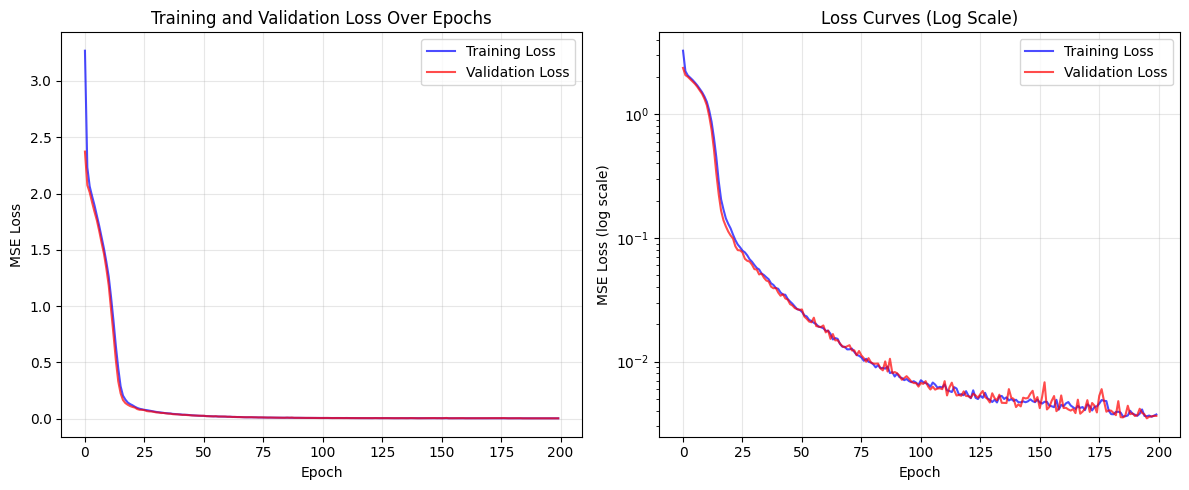

In [19]:
def plot_training_curves():
    """
    Plot training and validation loss curves from CSV logs.
    """
    # Try to read from CSV logger
    try:
        metrics_path = f"{csv_logger.log_dir}/metrics.csv"
        metrics_df = pd.read_csv(metrics_path)

        # Extract losses
        train_df = metrics_df[metrics_df['train_loss'].notna()][['epoch', 'train_loss']]
        val_df = metrics_df[metrics_df['val_loss'].notna()][['epoch', 'val_loss']]

        plt.figure(figsize=(12, 5))

        # Plot 1: Full loss curve
        plt.subplot(1, 2, 1)
        plt.plot(train_df['epoch'], train_df['train_loss'],
                 label='Training Loss', color='blue', alpha=0.7)
        plt.plot(val_df['epoch'], val_df['val_loss'],
                 label='Validation Loss', color='red', alpha=0.7)
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss')
        plt.title('Training and Validation Loss Over Epochs')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot 2: Log scale
        plt.subplot(1, 2, 2)
        plt.plot(train_df['epoch'], train_df['train_loss'],
                 label='Training Loss', color='blue', alpha=0.7)
        plt.plot(val_df['epoch'], val_df['val_loss'],
                 label='Validation Loss', color='red', alpha=0.7)
        plt.xlabel('Epoch')
        plt.ylabel('MSE Loss (log scale)')
        plt.title('Loss Curves (Log Scale)')
        plt.yscale('log')
        plt.legend()
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not read CSV logs: {e}")
        # Fallback: use model's internal tracking
        if model.train_losses and model.val_losses:
            plt.figure(figsize=(10, 5))
            plt.plot(model.train_losses, label='Training Loss', color='blue')
            plt.plot(model.val_losses, label='Validation Loss', color='red')
            plt.xlabel('Epoch')
            plt.ylabel('MSE Loss')
            plt.title('Training Progress')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.show()

plot_training_curves()

## 8. Test the Model

PyTorch Lightning provides a `test()` method to evaluate on the test set.

In [20]:
# Test the model
print("Testing model...")
test_results = trainer.test(model, data_module)
print(f"\nTest Results: {test_results}")

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing model...
Data split: Train=1440, Val=360, Test=200


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.003756457008421421    │
└───────────────────────────┴───────────────────────────┘


Test Results: [{'test_loss': 0.003756457008421421}]


## 9. Evaluate Model Performance

Let's evaluate the model with detailed metrics and visualizations.

Model Evaluation Metrics:
  MSE:  0.003756
  RMSE: 0.061290
  MAE:  0.046806
  R²:   0.997827


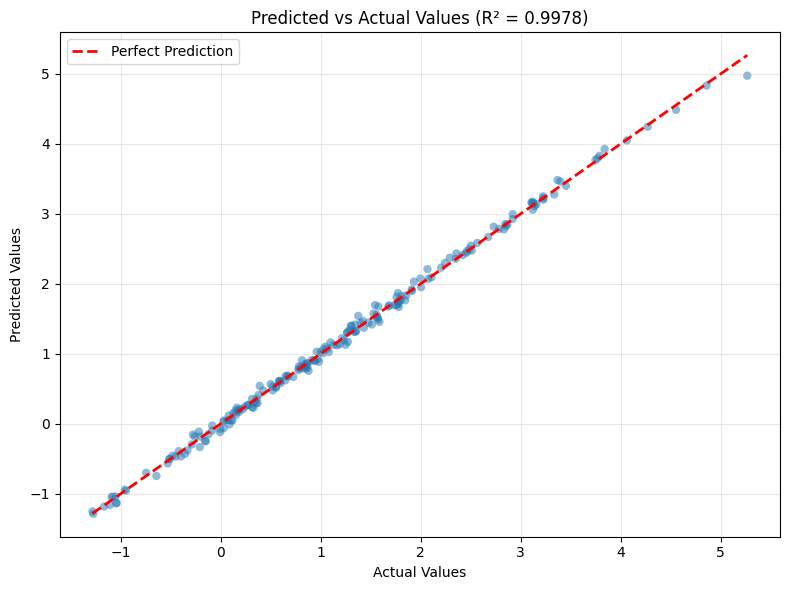

In [21]:
def evaluate_model(model, data_module):
    """
    Evaluate model performance with various metrics.
    """
    model.eval()

    # Get test data
    test_loader = data_module.test_dataloader()

    all_preds = []
    all_targets = []
    all_inputs = []

    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            pred = model(x)
            all_preds.append(pred.numpy())
            all_targets.append(y.numpy())
            all_inputs.append(x.numpy())

    y_pred = np.concatenate(all_preds).flatten()
    y_true = np.concatenate(all_targets).flatten()
    X_test = np.concatenate(all_inputs)

    # Calculate metrics
    mse = np.mean((y_pred - y_true)**2)
    mae = np.mean(np.abs(y_pred - y_true))
    rmse = np.sqrt(mse)

    ss_res = np.sum((y_true - y_pred)**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1 - (ss_res / ss_tot)

    print("Model Evaluation Metrics:")
    print(f"  MSE:  {mse:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  MAE:  {mae:.6f}")
    print(f"  R²:   {r2:.6f}")

    # Scatter plot
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5, edgecolors='none')
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Predicted vs Actual Values (R² = {r2:.4f})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    return X_test, y_pred, y_true

X_test, y_pred, y_true = evaluate_model(model, data_module)

## 10. 4D Visualization

We create visualizations to show the relationship between the 3 input variables and the predicted output.

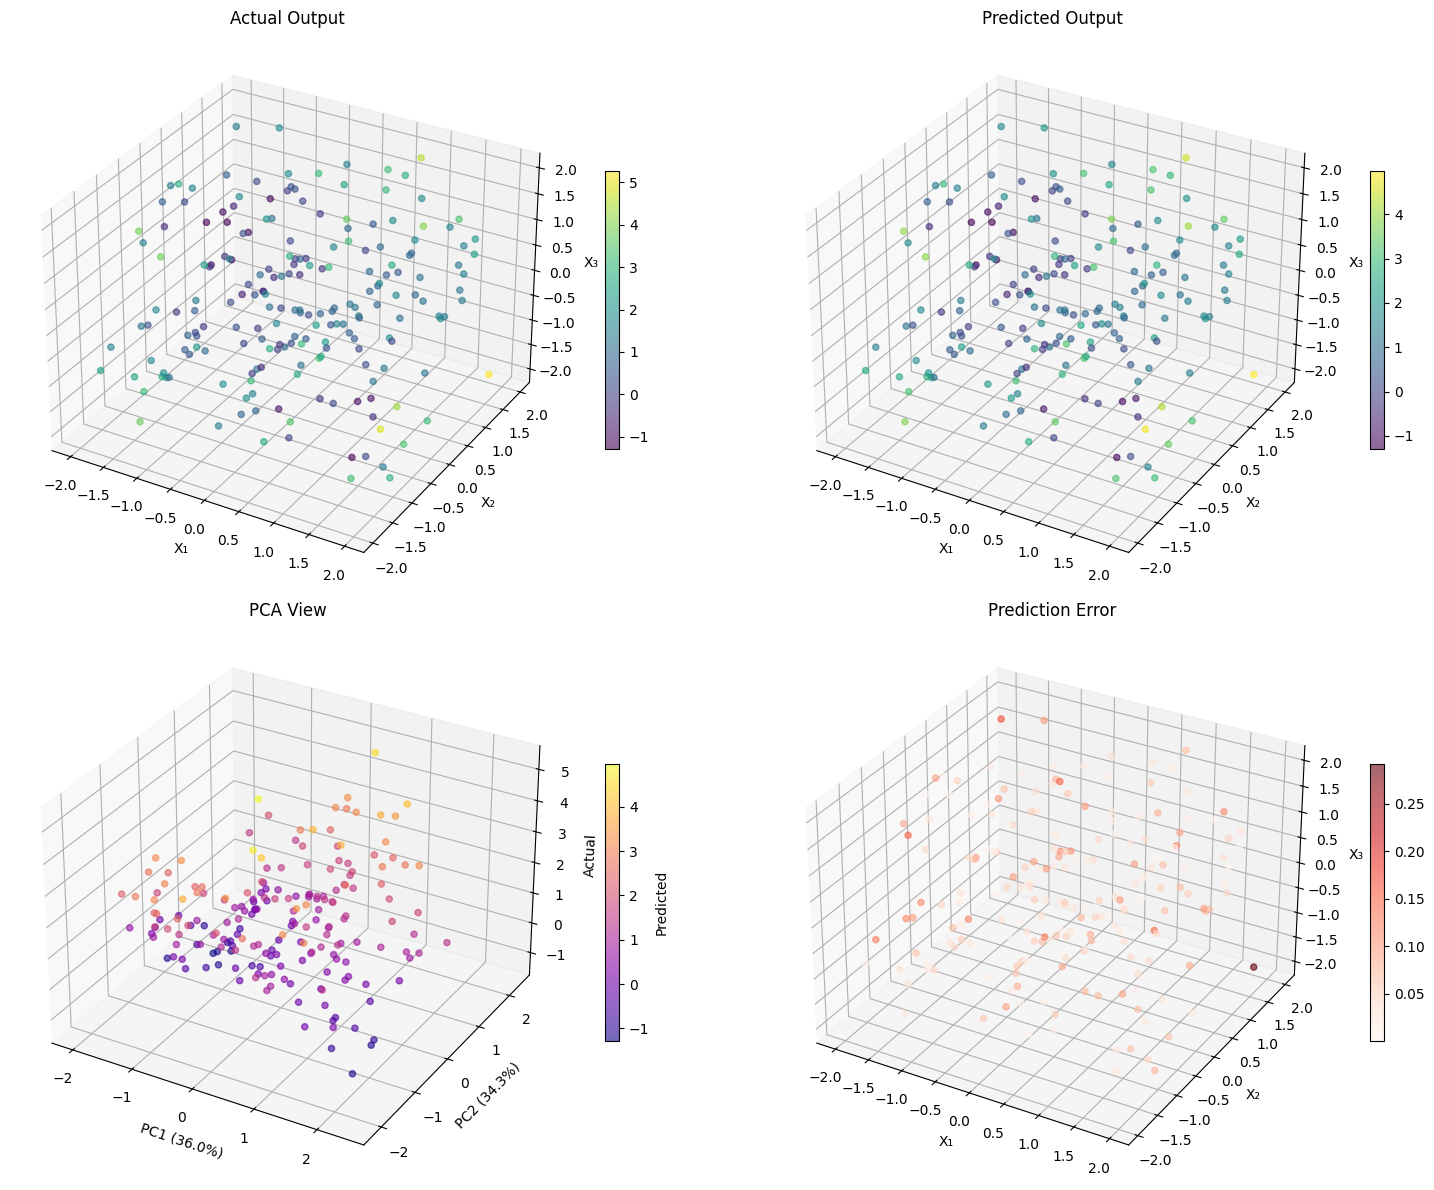

In [22]:
def plot_4d_visualization(X_test, y_pred, y_true):
    """
    Create 4D visualizations of the neural network predictions.
    """
    fig = plt.figure(figsize=(16, 12))

    # Plot 1: Actual output
    ax1 = fig.add_subplot(2, 2, 1, projection='3d')
    scatter1 = ax1.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                          c=y_true, cmap='viridis', alpha=0.6, s=20)
    ax1.set_xlabel('X₁')
    ax1.set_ylabel('X₂')
    ax1.set_zlabel('X₃')
    ax1.set_title('Actual Output')
    plt.colorbar(scatter1, ax=ax1, shrink=0.5)

    # Plot 2: Predicted output
    ax2 = fig.add_subplot(2, 2, 2, projection='3d')
    scatter2 = ax2.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                          c=y_pred, cmap='viridis', alpha=0.6, s=20)
    ax2.set_xlabel('X₁')
    ax2.set_ylabel('X₂')
    ax2.set_zlabel('X₃')
    ax2.set_title('Predicted Output')
    plt.colorbar(scatter2, ax=ax2, shrink=0.5)

    # Plot 3: PCA visualization
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_test)
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_scaled)

    ax3 = fig.add_subplot(2, 2, 3, projection='3d')
    scatter3 = ax3.scatter(X_pca[:, 0], X_pca[:, 1], y_true,
                          c=y_pred, cmap='plasma', alpha=0.6, s=20)
    ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
    ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
    ax3.set_zlabel('Actual')
    ax3.set_title('PCA View')
    plt.colorbar(scatter3, ax=ax3, shrink=0.5, label='Predicted')

    # Plot 4: Error
    error = np.abs(y_pred - y_true)
    ax4 = fig.add_subplot(2, 2, 4, projection='3d')
    scatter4 = ax4.scatter(X_test[:, 0], X_test[:, 1], X_test[:, 2],
                          c=error, cmap='Reds', alpha=0.6, s=20)
    ax4.set_xlabel('X₁')
    ax4.set_ylabel('X₂')
    ax4.set_zlabel('X₃')
    ax4.set_title('Prediction Error')
    plt.colorbar(scatter4, ax=ax4, shrink=0.5)

    plt.tight_layout()
    plt.savefig('4d_visualization_lightning.png', dpi=150, bbox_inches='tight')
    plt.show()

plot_4d_visualization(X_test, y_pred, y_true)

## 11. Load Best Model from Checkpoint

PyTorch Lightning automatically saves checkpoints. We can load the best model for inference.

In [23]:
# Load best model from checkpoint
if checkpoint_callback.best_model_path:
    best_model = NeuralNetworkLightning.load_from_checkpoint(
        checkpoint_callback.best_model_path
    )
    print(f"Loaded best model from: {checkpoint_callback.best_model_path}")
    print(f"Best validation loss: {checkpoint_callback.best_model_score:.6f}")
else:
    print("No checkpoint found, using current model")

Loaded best model from: /content/checkpoints/best-model-epoch=195-val_loss=0.0035.ckpt
Best validation loss: 0.003469


## 12. Summary and Key Takeaways

### PyTorch Lightning Structure:

| Component | Class | Purpose |
|-----------|-------|---------|
| Model | `LightningModule` | Define architecture + training logic |
| Data | `LightningDataModule` | Organize data loading |
| Training | `Trainer` | Handle training orchestration |
| Logging | `CSVLogger`, etc. | Track metrics |
| Callbacks | `EarlyStopping`, `ModelCheckpoint` | Control training behavior |

### Key Methods in LightningModule:
- `forward()`: Define forward pass
- `training_step()`: Logic for one training batch
- `validation_step()`: Logic for one validation batch
- `configure_optimizers()`: Setup optimizer and scheduler

### Benefits:
- ✅ Clean code organization
- ✅ Automatic GPU handling
- ✅ Built-in logging and checkpointing
- ✅ Easy to scale to multiple GPUs
- ✅ Reproducibility with seed_everything()

In [24]:
# Final summary
print("=" * 60)
print("COLAB D - PYTORCH LIGHTNING IMPLEMENTATION SUMMARY")
print("=" * 60)
print(f"\nTarget Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂")
print(f"\nArchitecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)")
print(f"\nData Module: RegressionDataModule")
print(f"  - Train/Val/Test splits handled automatically")
print(f"  - Batch size: {data_module.batch_size}")
print(f"\nTrainer Configuration:")
print(f"  - Max epochs: {trainer.max_epochs}")
print(f"  - Early stopping patience: 20")
print(f"  - Best checkpoint saved")
print(f"\nBest Validation Loss: {checkpoint_callback.best_model_score:.6f}")
print(f"\nPyTorch Lightning Components Used:")
print("  ✓ LightningModule (model + training logic)")
print("  ✓ LightningDataModule (data organization)")
print("  ✓ Trainer (training orchestration)")
print("  ✓ EarlyStopping callback")
print("  ✓ ModelCheckpoint callback")
print("  ✓ CSVLogger")
print("=" * 60)

COLAB D - PYTORCH LIGHTNING IMPLEMENTATION SUMMARY

Target Function: y = sin(x₁)·cos(x₂) + x₃² + 0.5·x₁·x₂

Architecture: 3 → 64 (Tanh) → 32 (Tanh) → 1 (Linear)

Data Module: RegressionDataModule
  - Train/Val/Test splits handled automatically
  - Batch size: 64

Trainer Configuration:
  - Max epochs: 200
  - Early stopping patience: 20
  - Best checkpoint saved

Best Validation Loss: 0.003469

PyTorch Lightning Components Used:
  ✓ LightningModule (model + training logic)
  ✓ LightningDataModule (data organization)
  ✓ Trainer (training orchestration)
  ✓ EarlyStopping callback
  ✓ ModelCheckpoint callback
  ✓ CSVLogger
